# Geopandas Example \#3: Buffers & Polygon Intersect

The City of Denver (my current home) conveniently has some great geographic data available for download. In this example, we will use City of Denver neighborhood boundaries and Denver Regional Transportation District (RTD) lightrail stations data to explore neighborhood access to the lightrail.

### This is a geopandas example covering the following:
1. Local Data:
    - Selecting the correct map projection for a local map
    - Plotting Denver neighborhoods
    - Denver lightrail lines and stations
2. Distance Analysis with Buffers:
    - Making a buffer around point data
    - Intersection of buffer areas and neighborhood polygons

### Read In the Data

In [1]:
# usual packages
import os
import pandas as pd
import numpy as np

In [2]:
# map-related packages
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import fiona

In [3]:
# set working directory
working_dir = '/Users/sarahrunkle/Desktop/git_desktop'
os.chdir(working_dir)

In [4]:
# read in the states data
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2017.html
states_file = working_dir + '/geo_data/states/states_cb_2017/cb_2017_us_state_500k.shp'
states_orig = gpd.read_file(states_file)

In [5]:
# Denver neighborhoods
# https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-statistical-neighborhoods
neighborhoods_file = working_dir + '/geo_data/statistical_neighborhoods/statistical_neighborhoods.shp'
neighborhoods_orig = gpd.read_file(neighborhoods_file )

According to denvergov.org, "The Statistical Neighborhood boundaries were developed in 1970 by the Community Renewal Program (CRP) which was administered by the current Denver Department of Community Planning and Development. Statistical Neighborhoods are typically combinations of census tracts. Geographic place names, such as Windsor and Mar Lee, were assigned to each area and reflect commonly used names of subdivisions and historical parts of the city."

In [6]:
# read in the Lightrail Stations
# http://gis-rtd-denver.opendata.arcgis.com/search?tags=transportation
stations_file = working_dir + '/geo_data/LightrailStations/LightrailStations.shp'
stations_orig = gpd.read_file(stations_file)

In [7]:
# also the Lightrail Lines
lines_file = working_dir + '/geo_data/LightrailLines_Center/LightrailLines_Center.shp'
lines_orig = gpd.read_file(lines_file)

### Check Map Projections
Map projections are a complex topic, and this example barely scratches the surface. Check out the ["Helpful Links"](#helpful-links) at the end of this notebook for more info. 

For the full U.S. map examples (geopandas examples #1 and #2), I used the "US National Atlas Equal Area" projection (epsg:2163), which works well for general visualizations. For this example, because we will be doing a distance analysis on a small scale, it is important to use a more local projection to minimize distortion. 

The data I have read in above currently use different projections, so the first step will be to re-project some of the data to ensure all projections match. From the geopandas docs, "Re-projecting is the process of changing the representation of locations from one coordinate system to another. All projections of locations on the Earth into a two-dimensional plane are distortions, the projection that is best for your application may be different from the projection associated with the data you import." 


To start, let's check out the original projection of each of the data sources. Then we can consider which projection is best for this particular analysis. 

In [8]:
# original crs
print('states: ' + str(states_orig.crs))
print('stations: ' + str(stations_orig.crs))
print('lines: ' + str(lines_orig.crs))
print('neighborhoods: ' + str(neighborhoods_orig.crs))

states: {'init': 'epsg:4269'}
stations: {'init': 'epsg:4326'}
lines: {'init': 'epsg:4326'}
neighborhoods: {'init': 'epsg:4326'}


The original datasets are in a mix of projections. Stations, lines, and neighborhoods are in epsg:4326 (also known as WGS84, the projection most commonly used for GPS). The states data is in epsg:4269 (also known as NAD83). 

We have to pick one projection for all of these data sets in order to plot them all together. 

Because of the small scale of the maps we're going to make, the most likely candidates for this example would be to use either the local State Plane Coordinate System (SPCS) or the local zone of the Universal Transverse Mercator (UTM) projection.

<center>State Plane</center> | <center>UTM</center>
- | - 
![State Plane](img/state_plane.png)|![UTM](img/utm.png) 


Image Source: gisgeography.com [UTM](https://gisgeography.com/utm-universal-transverse-mercator-projection/) and [SPCS](https://gisgeography.com/state-plane-coordinate-system-spcs/)

SPCS is technically better at minimizing distortion, but it shouldn't matter with the level of accuracy we need for this analysis. UTM is a very commonly used projection and is simpler to understand because it can be visualized easily (see image above).  The world is split into 60 UTM zones; Denver is in UTM Zone 13N, so let's re-project all of these datasets to UTM Zone 13N (epsg:26913).


In [9]:
# convert all data to epsg:26913 
states2 = states_orig.to_crs({'init': 'epsg:26913'})
stations2 = stations_orig.to_crs({'init': 'epsg:26913'})
lines2 = lines_orig.to_crs({'init': 'epsg:26913'})
neighborhoods2 = neighborhoods_orig.to_crs({'init': 'epsg:26913'})

### Basic Map of Colorado

In [10]:
# drop columns we don't need
states3 = states2[['STUSPS', 'NAME', 'geometry']]
# re-name columns
states3 = states3.rename(columns={'STUSPS':'state_code',
                                   'NAME': 'state_name'})

In [11]:
# just want Colorado for this example
co_data = states3[states3['state_code']=='CO']

In [12]:
# create a function to plot basic map of the U.S.
# this will be used frequently throughout examples below
def plot_basic_map(title):
    # create figure and axes
    fig, ax = plt.subplots(1, figsize=(16,12))
    # get rid of axis marks
    ax.axis('off')
    # add the states_data in
    co_data.plot(ax=ax,
                 color='#f0f0f5',
                 linewidth=2.0,
                 edgecolor='#666699')
    # set title of map based on function input
    ax.set_title(title, fontsize=20)
    
    return fig

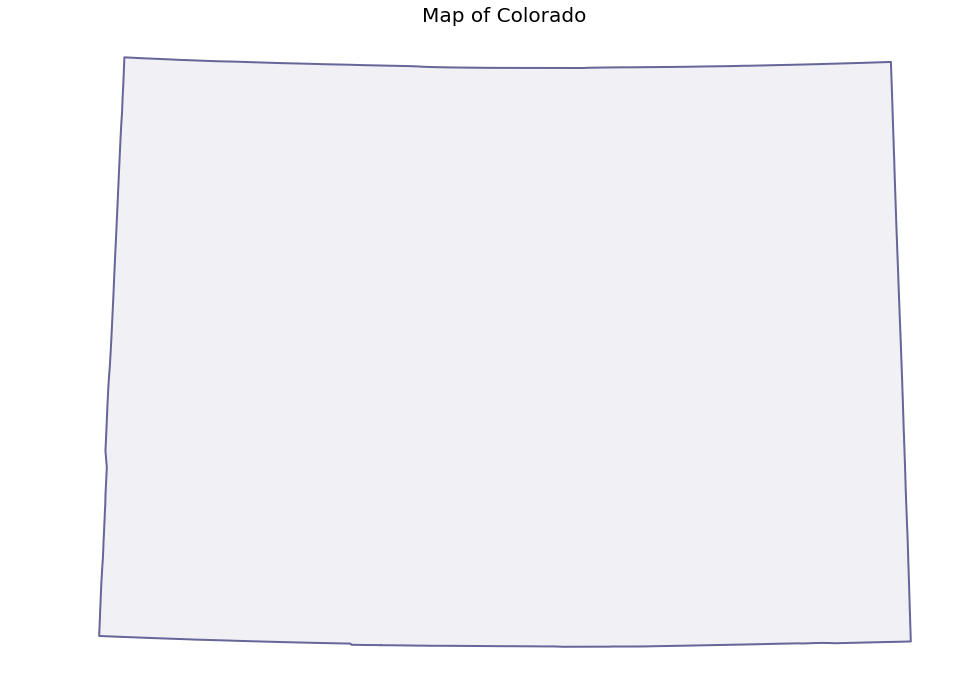

In [13]:
# call the function to check out the basic map
base_map = plot_basic_map('Map of Colorado')

While we're at it, let's set up another function we'll use a lot. This will set up the xy bounds of the map view. Note that this function works well specifically for the zone we are in (UTM 13N, which has all positive coordinates). This function may need to be adapted depending on the signs of a given geography's total bounds (min x, min y, max x, max y).

In [14]:
def map_bounds(geography, padding):    
    # get the total bounds of the geography
    min_x, min_y, max_x, max_y = geography.total_bounds
    
    # transform bounds
    min_x = min_x*(1-padding)
    min_y = min_y*(1-padding)
    max_x = max_x*(1+padding)
    max_y = max_y*(1+padding)
    
    return min_x, min_y, max_x, max_y

### Check Out the Neighborhoods Data

In [15]:
neighborhoods2.shape

(78, 5)

In [16]:
neighborhoods2.head(2)

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,geometry
0,2,Auraria,None,None,"POLYGON ((499963.8805293419 4399513.036617749,..."
1,21,Cory - Merrill,None,None,"POLYGON ((505084.5362825633 4393952.669154511,..."


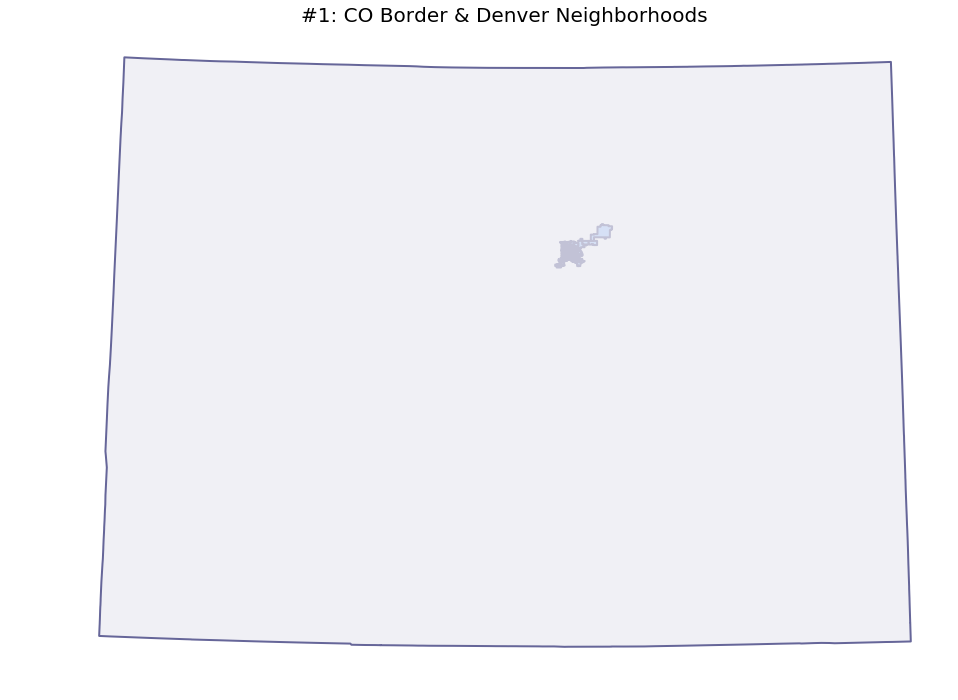

In [17]:
# create map
map1 = plot_basic_map('#1: CO Border & Denver Neighborhoods')

# plot neighborhoods
neighborhoods2.plot(ax=map1.gca(),
                    color='#d6e0f5',
                    linewidth=2.0,
                    edgecolor='#c2c2d6')

Here we can see a map of Colorado with Denver neighborhoods. At this scale, any mapped analysis of the Denver area would be pretty useless. I want to zoom in to the Denver area, so let's use the map_bounds() function.

(4376185.568998631, 4427117.310016408)

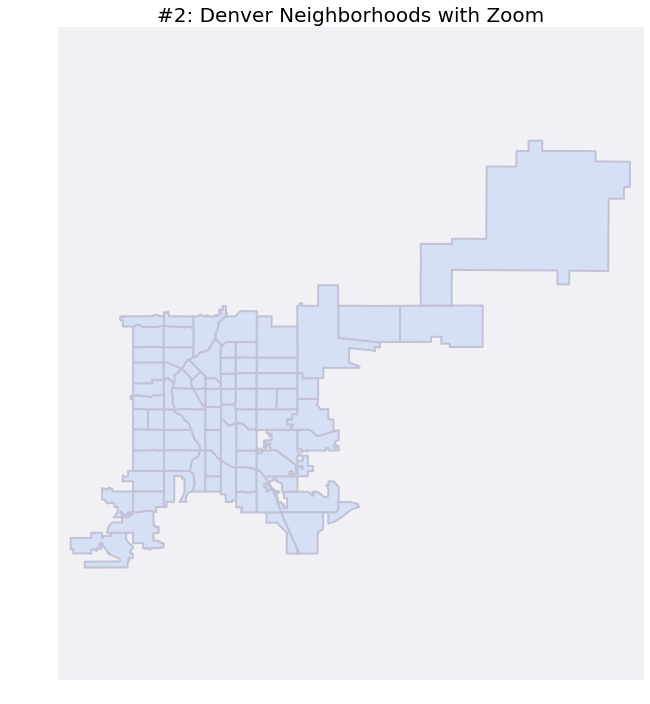

In [18]:
# create map
map2 = plot_basic_map('#2: Denver Neighborhoods with Zoom')

# plot neighborhoods
neighborhoods2.plot(ax=map2.gca(),
                    color='#d6e0f5',
                    linewidth=2.0,
                    edgecolor='#c2c2d6')

# set the bounds to zoom in to the Denver area
min_x, min_y, max_x, max_y = map_bounds(neighborhoods2, (2/1000))
map2.gca().set_xlim(min_x, max_x)
map2.gca().set_ylim(min_y, max_y)

A centroid is the xy center of a given polygon. Let's create some centroids for these neighborhoods. We can use the centroid location to label each neighborhood polygon at the center of the polygon.

In [19]:
# get just the XY centroid from the polygon of the neighborhood

# create centroid coordinates for neighborhood2
# we can see here that the geometry is a polygon and the centroid is a point
neighborhoods2['centroid'] = neighborhoods2['geometry'].centroid
neighborhoods2.head(2)

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,geometry,centroid
0,2,Auraria,None,None,"POLYGON ((499963.8805293419 4399513.036617749,...",POINT (499291.712975657 4399546.438601601)
1,21,Cory - Merrill,None,None,"POLYGON ((505084.5362825633 4393952.669154511,...",POINT (504302.4399967914 4393403.651744644)


In [20]:
# example centroid coordinates -- first row neighborhood (Auraria)
print('centroid x coord: ' + str(neighborhoods2[:1].centroid.x[0]))
print('centroid y coord: ' + str(neighborhoods2[:1].centroid.y[0]))

centroid x coord: 499291.71297565696
centroid y coord: 4399546.438601601


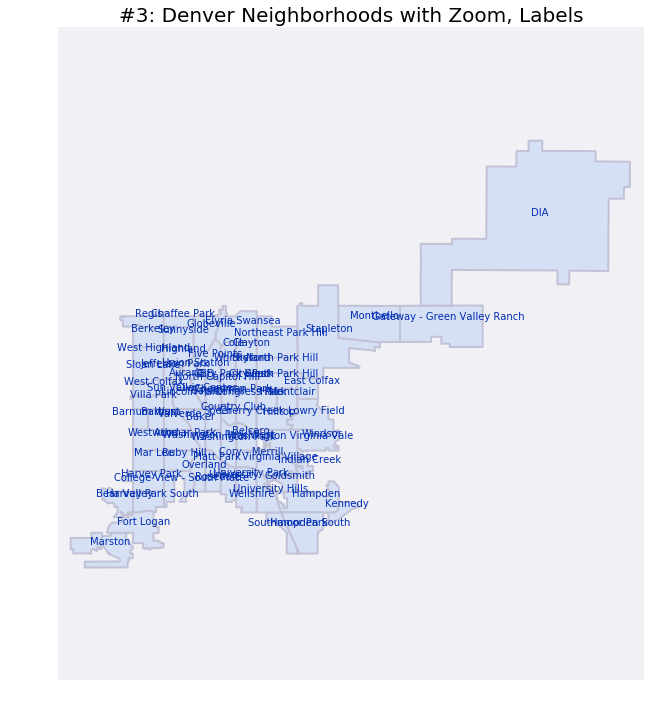

In [21]:
# create map
map3 = plot_basic_map('#3: Denver Neighborhoods with Zoom, Labels')

# plot neighborhoods
neighborhoods2.plot(ax=map3.gca(),
                    color='#d6e0f5',
                    linewidth=2.0,
                    edgecolor='#c2c2d6')

# set the bounds to zoom in to the Denver area
min_x, min_y, max_x, max_y = map_bounds(neighborhoods2, (2/1000))
map3.gca().set_xlim(min_x, max_x)
map3.gca().set_ylim(min_y, max_y)

for x, y, label in zip(neighborhoods2.centroid.x, neighborhoods2.centroid.y, neighborhoods2['NBHD_NAME']):
    map3.gca().annotate(label, xy=(x, y), xytext=(5, 5),
                        fontsize=10, color='#002db3',
                        textcoords='offset points', ha='center')

The map above is pretty overwhelming. If we were looking at only a few neighborhoods, these labels might be helpful; for now, let's leave the labels off. 

For the rest of this example, I'm interested specifically in the more "metropolitan" area of Denver, which I will define as everything Stapleton and west in this map.

In [22]:
# here, I'm changing the neighborhood limits to not include anything East of Stapleton
remove_list = ['Montbello', 'Gateway - Green Valley Ranch', 'DIA']
neighborhoods3 = neighborhoods2.copy()
neighborhoods3 = neighborhoods3.loc[~neighborhoods2['NBHD_NAME'].isin(remove_list)]
neighborhoods3.shape

(75, 6)

## Check out the Lightrail Stations & Lightrail Lines Data

In [23]:
stations2.head(2)

,OBJECTID,PID,NAME,SPECIAL_RT,ADDRESS,CLASS,CITY,ZIPCODE,PARCEL_ID_,CreationDa,Creator,EditDate,Editor,geometry
0,1,64,Littleton / Mineral Station,C-D,7500 S Platte River Pkwy,LRT,Littleton,80120,24896,2019-05-16T20:51:58.060Z,rtdgis,2019-05-16T20:51:58.060Z,rtdgis,POINT (497850.2827690785 4381153.671415619)
1,2,63,Littleton / Downtown Station,C-D,5780 S Prince St,LRT,Littleton,80120,"25438 (SouthBound) , 24894 (NorthBound)",2019-05-16T20:51:58.060Z,rtdgis,2019-05-16T20:51:58.060Z,rtdgis,POINT (498722.9401815591 4384691.773831653)


In [24]:
# cut down data to columns we want
stations3 = stations2[['NAME', 'CITY', 'geometry']]

In [25]:
# lines data
lines2.shape

(84, 9)

In [26]:
lines2.head(2)

,OBJECTID,PROJECTCOR,SOURCE,CreationDa,Creator,EditDate,Editor,Shape__Len,geometry
0,1,110,A-Line,2019-05-16T20:51:58.969Z,rtdgis,2019-05-16T20:51:58.969Z,rtdgis,87291.422422,(LINESTRING (499906.573826661 4400359.73790649...
1,2,112,G-Line,2019-05-16T20:51:58.969Z,rtdgis,2019-05-16T20:51:58.969Z,rtdgis,35177.373865,(LINESTRING (488202.2836097309 4404103.0231784...


In [27]:
# while we're at it, let's plot and label Union Station, which is the main transit hub in Denver
union_station = stations3.loc[stations3['NAME']=='Union Station Transit Center']
union_station

,NAME,CITY,geometry
52,Union Station Transit Center,Denver,POINT (499701.7952306202 4400554.94209913)


Text(-5, 10, 'Union Station')

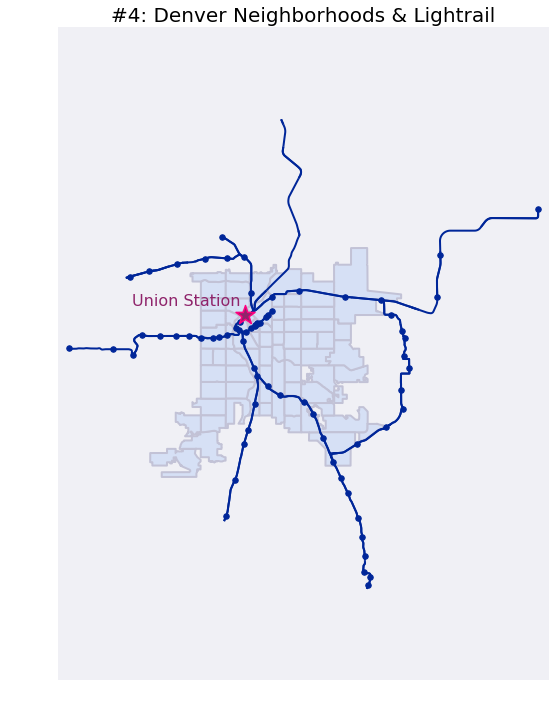

In [28]:
# create map
map4 = plot_basic_map('#4: Denver Neighborhoods & Lightrail')

# plot neighborhoods
neighborhoods3.plot(ax=map4.gca(),
                    color='#d6e0f5',
                    linewidth=2.0,
                    edgecolor='#c2c2d6',
                    zorder=1)

# plot the station points
stations3.plot(ax=map4.gca(), 
               color='#002699', 
               markersize=30,
               zorder=3)

# plot union station
union_station.plot(ax=map4.gca(),
                   color='#8f246b',
                   marker='*',
                   markersize=400,
                   linewidth=1.5,
                   edgecolor='#ff0080',
                   label='Union Station',
                   zorder=4)

# plot the lightrail lines
lines2.plot(ax=map4.gca(), 
            color='#002699', 
            linewidth=2.0,
            zorder=2)

# set the bounds to zoom in to the Denver area
# here actually using lightrail lines bounds
min_x, min_y, max_x, max_y = map_bounds(lines2, (2/1000))
map4.gca().set_xlim(min_x, max_x)
map4.gca().set_ylim(min_y, max_y)


# add label for Union Station
map4.gca().annotate(text='Union Station', 
                    xy=(union_station.geometry.x, union_station.geometry.y), 
                    textcoords='offset points', 
                    xytext=(-5, +10), # offset upper right from point
                    fontsize=16, 
                    color='#8f246b',
                    ha='right')

### Create Some Buffers
Which neighborhoods in Denver have the best and worst access to lightrail stations? To figure this out, we will create some buffers (distance-based circles) around the lightrail stations. By plotting these buffers, we will be able to start visualizing lightrail station accessibility within the city.

In [29]:
# check out the current geometry
stations3['geometry'].head(2)

0    POINT (497850.2827690785 4381153.671415619)
1    POINT (498722.9401815591 4384691.773831653)
Name: geometry, dtype: object

In [30]:
stations3.head()

,NAME,CITY,geometry
0,Littleton / Mineral Station,Littleton,POINT (497850.2827690785 4381153.671415619)
1,Littleton / Downtown Station,Littleton,POINT (498722.9401815591 4384691.773831653)
2,Oxford-City of Sheridan Station,Englewood,POINT (499586.2533697985 4388123.53480276)
3,Alameda Station,Denver,POINT (500585.3608786032 4395424.522562963)
4,18th St / California Station,Denver,POINT (500832.0429301551 4399632.712869001)


In [31]:
# IMPORTANT -- note that the buffer will be in same units as the projection
# for UTM, units are in meters
# convert miles to meters for the buffer
buffer_miles = 1
buffer_meters = buffer_miles*1609.344
buffer_meters

1609.344

In [32]:
# create a buffer (radius=buffer_meters) around stations
# save the buffer geometry to new 'geometry' column
stations4 = stations3.copy()
stations4['geometry'] = stations4.geometry.buffer(buffer_meters)

In [33]:
stations4.head(2)

,NAME,CITY,geometry
0,Littleton / Mineral Station,Littleton,"POLYGON ((499459.6267690785 4381153.671415619,..."
1,Littleton / Downtown Station,Littleton,"POLYGON ((500332.2841815591 4384691.773831653,..."


(4365795.904809866, 4419566.102400128)

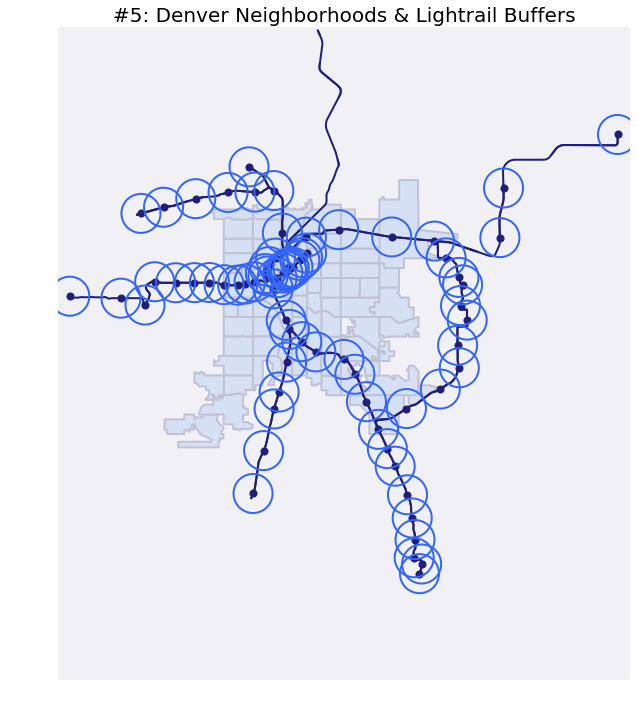

In [34]:
# create map
map5 = plot_basic_map('#5: Denver Neighborhoods & Lightrail Buffers')

# plot neighborhoods
neighborhoods3.plot(ax=map5.gca(),
                    color='#d6e0f5',
                    linewidth=2.0,
                    edgecolor='#c2c2d6',
                    zorder=1)

# plot the station points
stations2.plot(ax=map5.gca(), 
               color='#1f1f7a', 
               markersize=50,
               zorder=3)

# plot the station buffers
stations4.plot(ax=map5.gca(),
               color='None',
               linewidth=2.0,
               edgecolor='#3366ff',
               zorder=4)

# plot the lightrail lines
lines2.plot(ax=map5.gca(), 
                color='#1f1f7a', 
                linewidth=2.0,
                zorder=2)

# set the bounds to zoom in to the Denver area
# here actually using lightrail stations bounds
min_x, min_y, max_x, max_y = map_bounds(stations3, (2/1000))
map5.gca().set_xlim(min_x, max_x)
map5.gca().set_ylim(min_y, max_y)

From the above, we have a first step towards visualizing lightrail station accessibility within the city. 

We have 75 Denver neighborhoods here and over 80 lightrail stations. Which neighborhoods have the best access to a lightrail station? <b>To answer this question, I will find what percentage of each neighborhood falls within a buffer distance of any lightrail station.</b>

### Buffer Intersect Analysis

An important distinction here that will affect the rest of this analysis is that the question is "within a buffer distance of <b>any</b> lightrail station." 

Let's start with an overview of a buffer-intersect analysis. 

![intersect1](img/intersect1.png)
Image Source: [QGIS Buffers Documentation](https://docs.qgis.org/2.8/en/docs/gentle_gis_introduction/vector_spatial_analysis_buffers.html)

In the image above, we have a square (let's call it a neighborhood), and a circle, (let's call it a lightrail station buffer). The green area is the intersect of the neighborhood and the lightrail station buffer. If I wanted to know how much of the neighborhood is within the lightrail station buffer, I could divide the green area by the total area of the square.

<b>This gets more complicated quickly when we have multiple neighborhoods and multiple lightrail station buffers.</b>

![intersect2](img/intersect2.png)

Image Source: [QGIS Vector Overlay Documentation + added arrow](https://docs.qgis.org/testing/en/docs/user_manual/processing_algs/qgis/vectoroverlay.html)

In the image above, we have two red circles (1 & 2), intersected with a green circle (a). 1,a and 2,a are the intersected features. If I want to calculate the percentage of circle A that falls within the bounds of circle 1, I could divide the area of 1a by the area of circle A. Same goes for the percentage of circle A that falls within the bounds of circle 2 (divide area of 2,a by area of circle A). However -- what if I want to know the percentage of circle A that falls within EITHER circle 1 or circle 2 (intersected by any green circle)? Now I have to remember that the section labeled as 1,2,a falls within both 1,a and 2,a, and I don't want to double-count this area. If I'm calculating the area of circle A that falls within any part of a green circle, I would want (area of 1,a + area of 2,a - area of 1,2,a)/(circle A area).

### So...What Does That Mean for This Analysis?
Map #5 shows we have a lot of neighborhoods and a lot of lightrail station buffers. If I do an intersect between the neighborhoods and the buffers, the intersect dataframe will contain data for every intersected piece of each buffer and each neighborhood. For example, if my house falls within 1 mile of station A and also within 1 mile of station B, the area my house sits on will count as intersected area for both of these station buffers (just like area 1,2,a in the example above). If I then wanted to sum up the intersect areas for my neighborhood, <i>the area my house lies on would be summed twice</i>, which is incorrect.

To deal with this potential problem, I will first use the dissolve function on the lightrail buffers. This merges the lightrail station buffers into a single polygon.

In [35]:
# create a dissolve of the stations
stations5 = stations4.copy()
stations5['dissolve_cat'] = 1 # create dummy category to dissolve buffer polygons by
stations5_dissolve = stations5.dissolve(by='dissolve_cat')

(4365795.904809866, 4419566.102400128)

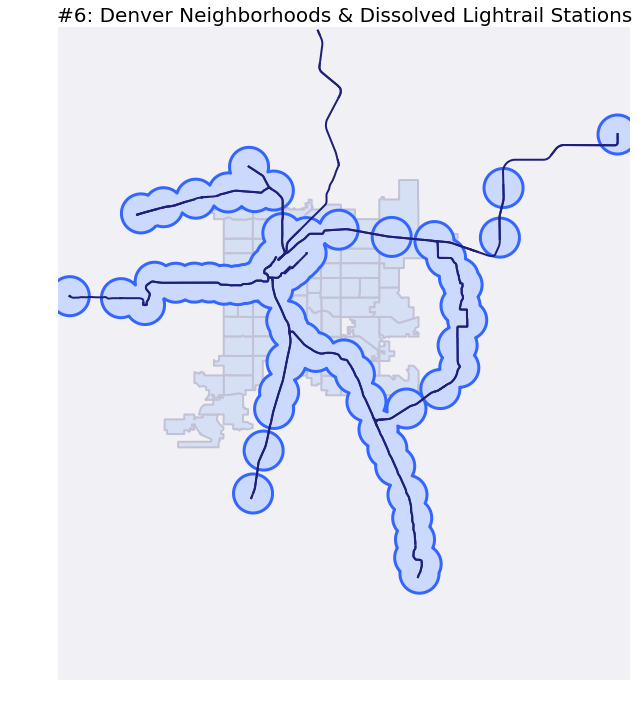

In [36]:
# create map
map6 = plot_basic_map('#6: Denver Neighborhoods & Dissolved Lightrail Stations')

# plot neighborhoods
neighborhoods3.plot(ax=map6.gca(),
                    color='#d6e0f5',
                    linewidth=2.0,
                    edgecolor='#c2c2d6',
                    zorder=1)

# plot the lightrail lines
lines2.plot(ax=map6.gca(), 
                color='#1f1f7a', 
                linewidth=2.0,
                zorder=3)

# plot the station points
stations5_dissolve.plot(ax=map6.gca(), 
                        color='#ccd9ff',
                        linewidth=3.0,
                        edgecolor='#3366ff',
                        zorder=2)


# set the bounds to zoom in to the Denver area
# here actually using lightrail station bounds
min_x, min_y, max_x, max_y = map_bounds(stations3, (2/1000))
map6.gca().set_xlim(min_x, max_x)
map6.gca().set_ylim(min_y, max_y)

In [37]:
# do the intersection
intersection = gpd.overlay(neighborhoods3, stations5_dissolve, how='intersection')

In [38]:
intersection.head(2)

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,centroid,NAME,CITY,geometry
0,2,Auraria,None,None,POINT (499291.712975657 4399546.438601601),Littleton / Mineral Station,Littleton,"POLYGON ((499963.8805293419 4399513.036617749,..."
1,21,Cory - Merrill,None,None,POINT (504302.4399967914 4393403.651744644),Littleton / Mineral Station,Littleton,"POLYGON ((505090.2206360396 4393791.156840539,..."


In [39]:
intersection.shape

(54, 8)

In [40]:
# only 54 of the neighborhoods have any overlap with the buffers -- each neighborhood has only one intersect area
# because we are intersecting the neighborhood and the dissolved lightrail stations polygon
intersection['NBHD_NAME'].nunique()

54

In [41]:
# create area_sqm for the intersection
# this gives us the area in square miles of the intersected pieces
intersection['area_sqm'] = intersection['geometry'].area
intersection.head(2)

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,centroid,NAME,CITY,geometry,area_sqm
0,2,Auraria,None,None,POINT (499291.712975657 4399546.438601601),Littleton / Mineral Station,Littleton,"POLYGON ((499963.8805293419 4399513.036617749,...",1.670492e+06
1,21,Cory - Merrill,None,None,POINT (504302.4399967914 4393403.651744644),Littleton / Mineral Station,Littleton,"POLYGON ((505090.2206360396 4393791.156840539,...",1.830881e+06


(4365795.904809866, 4419566.102400128)

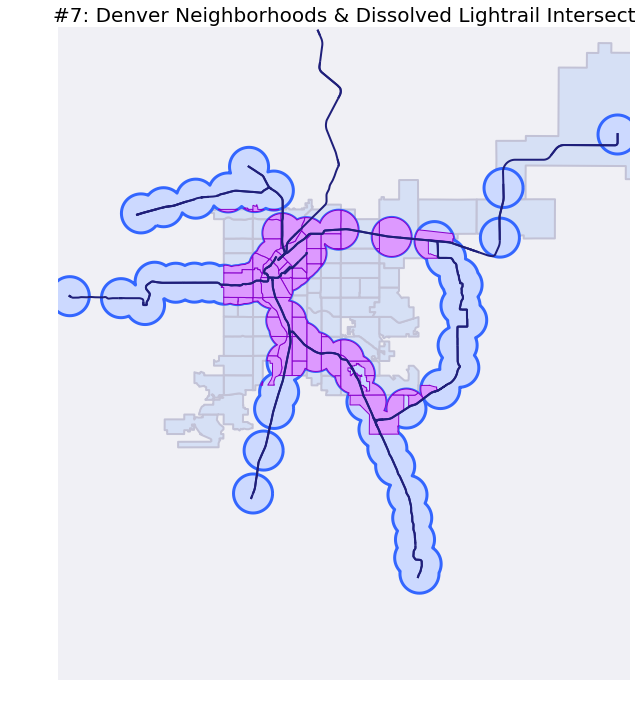

In [42]:
# create map
map7 = plot_basic_map('#7: Denver Neighborhoods & Dissolved Lightrail Intersect')

# plot neighborhoods
neighborhoods2.plot(ax=map7.gca(),
                    color='#d6e0f5',
                    linewidth=2.0,
                    edgecolor='#c2c2d6',
                    zorder=1)

# plot the lightrail lines
lines2.plot(ax=map7.gca(), 
                color='#1f1f7a', 
                linewidth=2.0,
                zorder=4)

# plot the station points
stations5_dissolve.plot(ax=map7.gca(), 
                        color='#ccd9ff',
                        linewidth=3.0,
                        edgecolor='#3366ff',
                        zorder=2)

# plot the intersection 
intersection.plot(ax=map7.gca(), 
                        color='#dd99ff',
                        linewidth=1.0,
                        edgecolor='#8800cc',
                        zorder=3)

# set the bounds to zoom in to the Denver area
# here actually using lightrail station bounds
min_x, min_y, max_x, max_y = map_bounds(stations3, (2/1000))
map7.gca().set_xlim(min_x, max_x)
map7.gca().set_ylim(min_y, max_y)

In [43]:
# also create area_sqm for the neighborhoods3 data
neighborhoods3['area_sqm'] = neighborhoods3['geometry'].area

In [44]:
# sum up the intersected area by neighborhood
pivot = intersection.groupby('NBHD_NAME')['area_sqm'].sum()

In [45]:
# format the pivot table
pivot = pivot.reset_index()
pivot = pivot.rename(columns={'area_sqm':'intersect_area'})
pivot.head(2)

,NBHD_NAME,intersect_area
0,Athmar Park,1.983040e+06
1,Auraria,1.670492e+06


In [46]:
# now merge this intersect data back to the neighborhoods data
neighborhoods4 = pd.merge(neighborhoods3, pivot, how='left',
                          on='NBHD_NAME')
neighborhoods4['intersect_area'] = neighborhoods4['intersect_area'].fillna(0)

In [47]:
# now we have the area of the neighborhood that lies within any lightrail station (intersect area)
# and also the entire neighborhood area
# calculate the intersect area as a percentage of the entire neighborhood area
neighborhoods4['pct_overlap'] = round((neighborhoods4['intersect_area']/neighborhoods4['area_sqm'])*100,0)

In [48]:
# check out the distribution of pct_overlap
neighborhoods4['pct_overlap'].describe()

count     75.000000
mean      47.920000
std       41.175222
min        0.000000
25%        0.000000
50%       47.000000
75%       94.500000
max      100.000000
Name: pct_overlap, dtype: float64

In [49]:
# check out how many neighborhoods fall into percentage ranges
bins = pd.cut(neighborhoods4['pct_overlap'], [-1, 0, 20, 40, 60, 80, 100])
bins_pivot = neighborhoods4.groupby(bins)['pct_overlap'].agg(['count'])
bins_pivot

,count
pct_overlap,
"(-1, 0]",21
"(0, 20]",6
"(20, 40]",7
"(40, 60]",10
"(60, 80]",6
"(80, 100]",25


In [50]:
# create binned 'access_categories' column based on percent overlap of neighborhood and any lightrail stationbin
neighborhoods4['access_categories'] = pd.cut(x=neighborhoods4['pct_overlap'], 
                                             bins=[-1, 20, 40, 60, 80, 100], 
                                             labels=[1, 2, 3, 4, 5])

(4365795.904809866, 4419566.102400128)

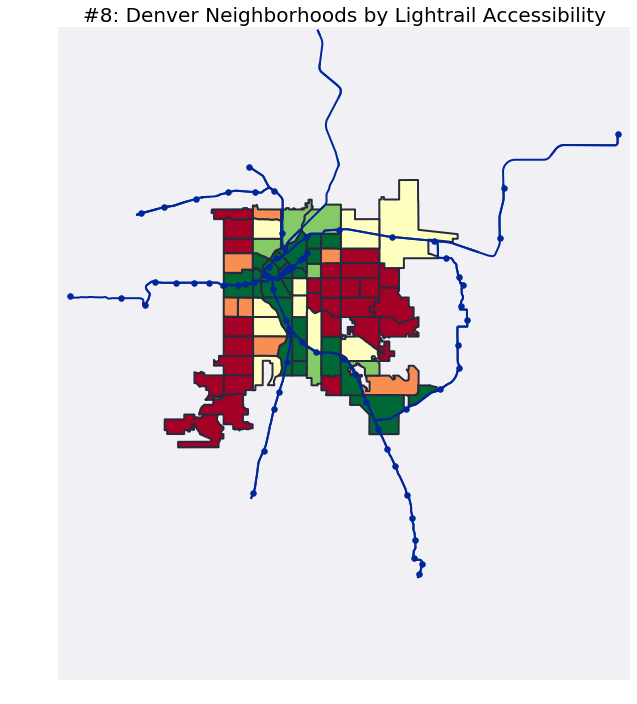

In [51]:
# create map 
map8 = plot_basic_map('#8: Denver Neighborhoods by Lightrail Accessibility')

# plot neighborhoods
neighborhoods4.plot(ax=map8.gca(),
                    column='access_categories',
                    cmap='RdYlGn',
                    linewidth=2.0,
                    edgecolor='#29293d',
                    zorder=1)

# plot the station points
stations3.plot(ax=map8.gca(), 
               color='#002699', 
               markersize=30,
               zorder=3)

# plot the lightrail lines
lines2.plot(ax=map8.gca(), 
            color='#002699', 
            linewidth=2.0,
            zorder=2)

# set the bounds to zoom in to the Denver area
# here actually using lightrail stations bounds
min_x, min_y, max_x, max_y = map_bounds(stations3, (2/1000))
map8.gca().set_xlim(min_x, max_x)
map8.gca().set_ylim(min_y, max_y)

In [52]:
# print out neighborhoods with best access to any lightrail station
# (>80% of total neighborhood area is within 1 mile of a lightrail station)
neighborhoods4.loc[neighborhoods4['access_categories']==5]['NBHD_NAME']

0                  Auraria
1           Cory - Merrill
4     Washington Park West
15             West Colfax
26                Rosedale
33         University Park
34              Platt Park
35                Overland
37                 Kennedy
39          Southmoor Park
40           Hampden South
44        University Hills
49      North Capitol Hill
50            Civic Center
51                     CBD
52           Union Station
58              Sun Valley
60              Villa Park
61             Five Points
64          Jefferson Park
67                   Baker
68                 Clayton
70            Lincoln Park
71                Whittier
72                    Cole
Name: NBHD_NAME, dtype: object

In [53]:
# print out neighborhoods with worst access to any lightrail station
# (<20% of total neighborhood area is within 1 mile of a lightrail station)
neighborhoods4.loc[neighborhoods4['access_categories']==1]['NBHD_NAME']

2                      Belcaro
6                 Cherry Creek
7                 Country Club
8                Congress Park
9                    City Park
10                     Marston
11                  Fort Logan
12    Washington Virginia Vale
16               West Highland
18                    Berkeley
19                       Regis
23                     Windsor
24                   Wellshire
27               Cheesman Park
28                     Hilltop
29                   Montclair
30                        Hale
31             North Park Hill
32             South Park Hill
41                Indian Creek
45                 Harvey Park
46                     Mar Lee
47                 East Colfax
54                 Lowry Field
55           Harvey Park South
63                 Bear Valley
73                    Westwood
Name: NBHD_NAME, dtype: object

And there we have it. If you're moving to Denver and looking for a lightrail-friendly neighborhood...you're in luck!

<a id='helpful-links'></a>
### Helpful Links

#### Coordinate Reference Systems (CRS) & Projections
- [Coordinate Reference Systems Overview](https://automating-gis-processes.github.io/CSC/notebooks/L2/projections.html)
- [Coordinate Systems, Projections, and Transformations Presentation](http://www.yorku.ca/ssii109/resources/GEOIDE_May_17_presentation.pdf)
- [What is a UTM Zone?](https://gisgeography.com/utm-universal-transverse-mercator-projection/)
- [Esri -- Universal Transverse Mercator](https://desktop.arcgis.com/en/arcmap/latest/map/projections/universal-transverse-mercator.htm)
- [Interactive Map -- Which UTM Zone am I In?](https://mangomap.com/robertyoung/maps/69585/What-UTM-Zone-am-I-in-#_)
- [UTM Zone 13N Info](https://spatialreference.org/ref/epsg/nad83-utm-zone-13n/)
- [Esri -- State Plane Coordinate System](http://desktop.arcgis.com/en/arcmap/10.3/guide-books/map-projections/state-plane-coordinate-system.htm)
- [Stack Overflow --  WGS84 a CRS?](https://gis.stackexchange.com/questions/23690/is-wgs84-itself-a-coordinate-reference-system)
- [Stack Overflow -- picking a crs](https://gis.stackexchange.com/questions/279109/calculate-distance-between-a-coordinate-and-a-county-in-geopandas)

#### Buffers & Buffer Analyses
- [Buffer Documentation](https://geopandas.readthedocs.io/en/latest/reference.html)
- [Set-Operations with Overlay](http://geopandas.org/set_operations.html)
- [QGIS Vector Operations](https://docs.qgis.org/2.8/en/docs/gentle_gis_introduction/vector_spatial_analysis_buffers.html)
- [Dissolve Function](http://geopandas.org/aggregation_with_dissolve.html)

#### Data Manipulation & Plotting
- [Stack Overflow -- Label Polygons](https://stackoverflow.com/questions/38899190/geopandas-label-polygons)
- [Stack Overflow -- Bins](https://www.reddit.com/r/learnpython/comments/73z4e2/pandas_groupby_or_cut_dataframe_to_bins/
)
- [Bins contd.](https://dfrieds.com/data-analysis/bin-values-python-pandas)


